In this notebook, my goal is to implement makemore using pytorch as explained in the different videos. It will only have the final implementation and is meant for comparison.

1. [Vanilla MLP](#Makemore-using-vanilla-MLP)
2. [Torch MLP Module](#Makemore-Torch-MLP-module)

# Dataset

In [9]:
words: list[str] = []

with open("data/names.txt", "r") as f:
    for l in f:
        words.append(l.strip())

In [12]:
# build the vocabulary of characters and mappings to/from integers

chars: list[str] = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

Creating an integer id mapping for every char helps us do embedding lookups and other things. 

In [34]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)

  return X, Y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

print(f"""
  Context Length: {block_size} 
  Training: {Xtr.shape}, {Ytr.shape}
  Dev: {Xdev.shape}, {Ydev.shape}
  Test: {Xte.shape}, {Yte.shape}
""")


  Context Length: 3 
  Training: torch.Size([182512, 3]), torch.Size([182512])
  Dev: torch.Size([22860, 3]), torch.Size([22860])
  Test: torch.Size([22774, 3]), torch.Size([22774])



## Makemore manual MLP

Build a MLP that does the following:

- Take 3 chars and one hot encode them
- Convert them into 3 embeddings and concat them
- Pass it through a two layer network

### Using the functional API

In [208]:
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

In [209]:
g = torch.Generator().manual_seed(12345)
dim = 10
C = torch.randn((27, dim), generator=g)

# rows = number of neurons
# cols = number of inputs to a neuron
W1 = torch.randn((200, 30), generator=g)
b1 = torch.randn((200, 1), generator=g)
W2 = torch.randn((27, 200), generator=g)
b2 = torch.randn((27, 1), generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f"n_params: {sum((p.nelement() for p in parameters)) }")

n_params: 11897


In [210]:
def training_loop(minibatch_size=200, steps=50000):
    loss_s, step_s = [], []

    for step in range(steps):
        ix = torch.randint(0, Xtr.shape[0], (minibatch_size,))
        embs = C[Xtr[ix]] # (min_batch , 3, 10)
        h = torch.tanh(W1 @ embs.view((-1, 30)).T + b1) # min_batch x 200 
        logits = W2 @ h + b2 # (min_batch, 27)
        loss = F.cross_entropy(logits.T, Ytr[ix])
        
        for p in parameters:
            p.grad = None
        loss.backward()
        
        lr = 0.1 if step < 100000 else 0.01
        for p in parameters:
            p.data += -lr * p.grad
        
        step_s.append(step)
        loss_s.append(loss.log10().item())

    return loss_s, step_s

loss_s, step_s = training_loop()

In [211]:
def loss(X, Y):
    embs = C[X] # (min_batch , 3, 10)
    h = torch.tanh(W1 @ embs.view((-1, 30)).T + b1) # min_batch x 200 
    logits = W2 @ h + b2 # (min_batch, 27)
    loss = F.cross_entropy(logits.T, Y)

    return loss

dev_l = dev_loss()

print(f"Training loss {loss(Xtr, Ytr)}")
print(f"Dev loss {loss(Xdev, Ydev)}")

Training loss 2.2245495319366455
Dev loss 2.239896059036255


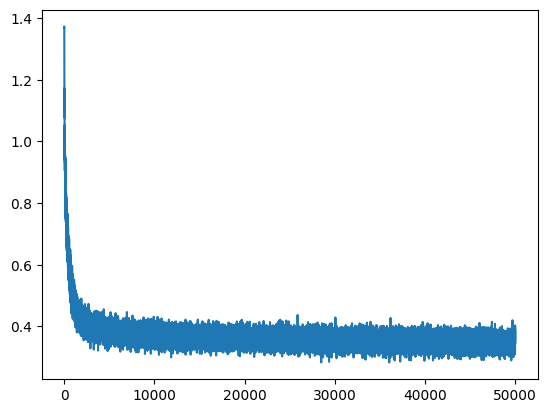

In [213]:
def sample_names(n=20, block_size=3):
    g = torch.Generator().manual_seed(1234)
    
    
    for _ in range(n):
        context = [0] * block_size
        out = []
        
        while True:
            embs = C[torch.tensor(context)] # (min_batch , 3, 10)
            h = torch.tanh(W1 @ embs.view((-1, 30)).T + b1) # min_batch x 200 
            logits = W2 @ h + b2 # 27, 1
            probs = F.softmax(logits, dim=0) 
            ix = torch.multinomial(probs.view(-1), num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break
                
        print(''.join([itos[i] for i in out]))

sample_names(30)

kembin.
adaxileigh.
vadar.
yace.
zyin.
treute.
kove.
gasia.
batti.
tregh.
yoviy.
idelin.
arma.
armenio.
thide.
makkenn.
kamina.
agtyl.
azkeist.
naleanges.
tianesilvy.
kharelo.
aad.
alanie.
dercti.
aeleigh.
ronia.
zyritterateni.
zarilah.
maridhleh.


## Makemore Torch MLP module

In [275]:
import torch
import torch.nn as nn

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [289]:
class MLP(nn.Module):
    def __init__(self, input_dim=10, block_size=3):
        """
        W1 = torch.randn((200, 30), generator=g)\
        b1 = torch.randn((200, 1), generator=g)
        W2 = torch.randn((27, 200), generator=g)
        b2 = torch.randn((27, 1), generator=g)
        """
        super().__init__()
        self.block_size = block_size
        self.embedding = nn.Embedding(27, input_dim)  # Assuming vocabulary size is 100 and embedding size is 10
        self.input_dim = input_dim
        self.layers = nn.Sequential(
            nn.Linear(input_dim * block_size, 200),
            nn.Tanh(),
            nn.Linear(200, 27)
        )

    def forward(self, x):
        emb = self.embedding(x).view(-1, self.input_dim * self.block_size)
        out = self.layers(emb)

        return out

In [292]:
sum(p.numel() for p in model.parameters())

11897

In [291]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [293]:
# Training loop
def training_loop(minibatch_size=200, steps=50000):
    loss_s, step_s = [], []

    for step in range(steps):
        ix = torch.randint(0, Xtr.shape[0], (minibatch_size,))
        inputs, targets = Xtr[ix], Ytr[ix]

        # Forward pass
        logits = model(inputs)
        loss = criterion(logits, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()

        # Adjust learning rate
        lr = 0.1 if step < 100000 else 0.01
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        optimizer.step()

        step_s.append(step)
        loss_s.append(loss.log10().item())

    return loss_s, step_s

loss_s, step_s = training_loop()

Training loss 2.0623111724853516
Dev loss 2.125647783279419


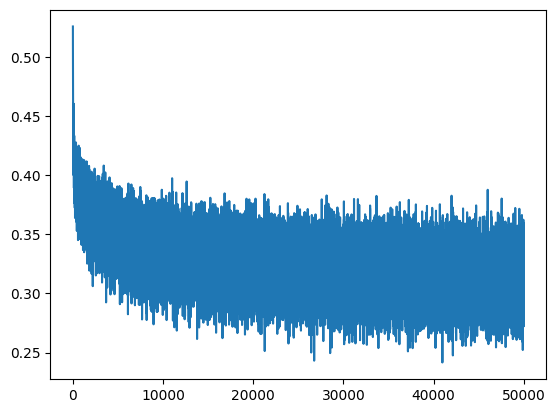

In [296]:
def loss(X, Y):
    logits = model(X)
    loss = F.cross_entropy(logits, Y)

    return loss

dev_l = dev_loss()

print(f"Training loss {loss(Xtr, Ytr)}")
print(f"Dev loss {loss(Xdev, Ydev)}")

plt.plot(step_s, loss_s)

In [295]:
@torch.no_grad()
def sample_names(n=20, block_size=3):
    g = torch.Generator().manual_seed(1234)
    
    
    for _ in range(n):
        context = [0] * block_size
        out = []
        
        while True:
            logits = model(torch.tensor(context))
            probs = F.softmax(logits, dim=1) 
            ix = torch.multinomial(probs.view(-1), num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break
                
        print(''.join([itos[i] for i in out]))

sample_names(30)

kend.
phadaliyane.
shadar.
yase.
cyia.
treutrino.
luccous.
braycen.
ewer.
jassiinnley.
cama.
armenio.
whidoff.
kionnie.
bena.
agnylah.
kaislyn.
leang.
sevianesteverendreno.
aad.
has.
terrowani.
aeleigh.
ron.
aazi.
haseem.
emile.
shraglo.
kadreah.
evey.
